### 캘리포니아 주택 가격 예측
인구, 중간소득 등의 특성을 활용하여 중간 주택가격예측     

레이블된 훈련 샘플이 있고 값을 예측해야하는 문제이기 때문에 지도학습의 회귀 문제이다. 사용할 특성이 여러개기 때문에 단변량회귀, 구역마다 여러 값을 예측한다면 다변량 회귀문제 입니다. 시스템으로 들어오는 데이터에 연속적인 흐름이 없으므로 빠르게 변하는 데이터에 적응하지 않아도 되고 , 데이터가 메모리에 들어갈 만큼 충분히 작으므로 일반적인 배치 학습이 적절합니다.

#### 성능 지표 선택
회귀문제의 전형적인 성능 지표는 평균제곱오차(RMSE) 오차가 커질 수록 이 값은 더욱 커지므로 예측에 얼마나 많은 오류가 있는지 가늠하게 해준다.  
평균절대오차(MAE) 이상치로 보이는 구역이 많을 시 유용

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [3]:
df = pd.read_csv('data/housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


<AxesSubplot:>

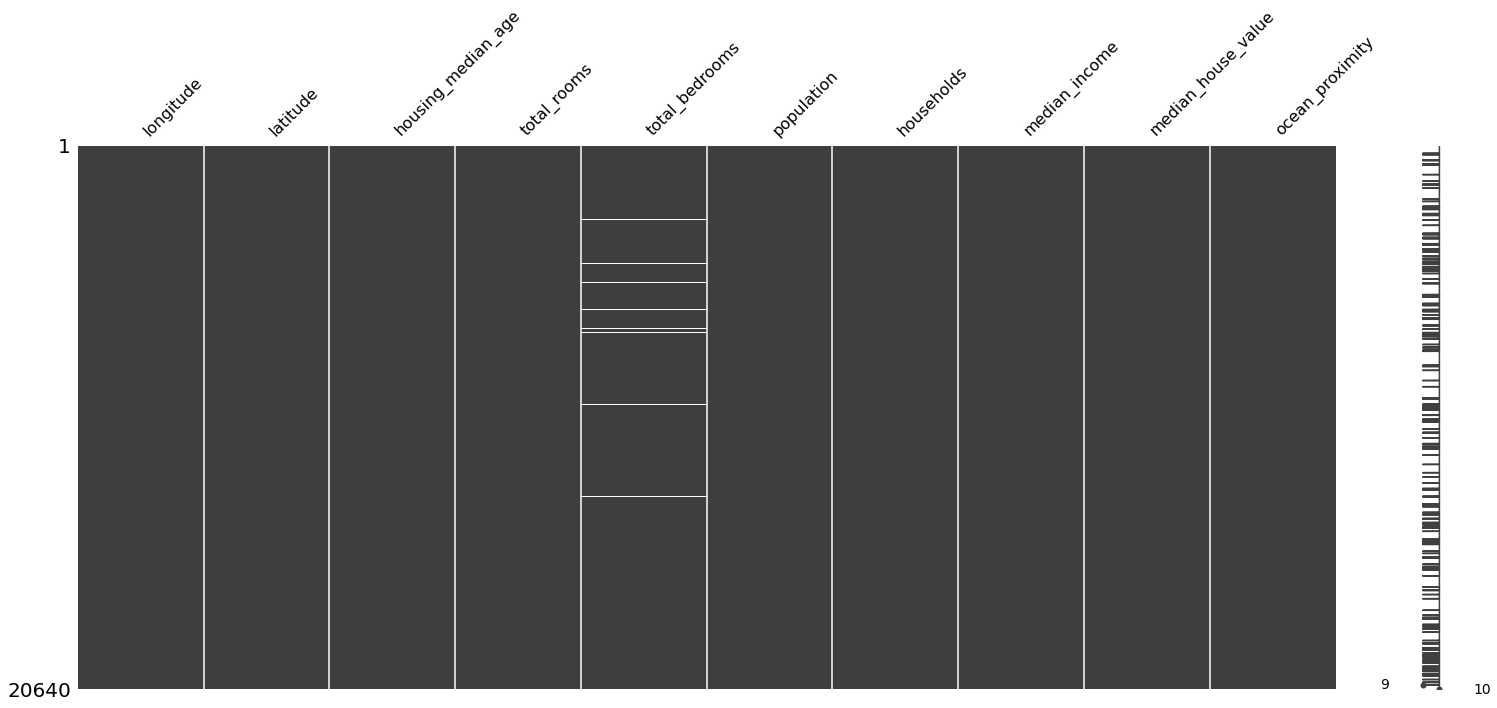

In [5]:
# null 값 시각화
import missingno as msno

msno.matrix(df)

In [6]:
# null 값 보기 
tot = df.isnull().sum().sort_values(ascending=False)
pct = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([tot, pct], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
total_bedrooms,207,0.010029
longitude,0,0.000000
latitude,0,0.000000
housing_median_age,0,0.000000
total_rooms,0,0.000000
population,0,0.000000
households,0,0.000000
median_income,0,0.000000
median_house_value,0,0.000000
ocean_proximity,0,0.000000


In [7]:
df['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [8]:
df.describe().round(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.00,20640.00,20640.00,20640.00,20433.00,20640.00,20640.00,20640.00,20640.00
mean,-119.57,35.63,28.64,2635.76,537.87,1425.48,499.54,3.87,206855.82
std,2.00,2.14,12.59,2181.62,421.39,1132.46,382.33,1.90,115395.62
min,-124.35,32.54,1.00,2.00,1.00,3.00,1.00,0.50,14999.00
25%,-121.80,33.93,18.00,1447.75,296.00,787.00,280.00,2.56,119600.00
50%,-118.49,34.26,29.00,2127.00,435.00,1166.00,409.00,3.53,179700.00
75%,-118.01,37.71,37.00,3148.00,647.00,1725.00,605.00,4.74,264725.00
max,-114.31,41.95,52.00,39320.00,6445.00,35682.00,6082.00,15.00,500001.00


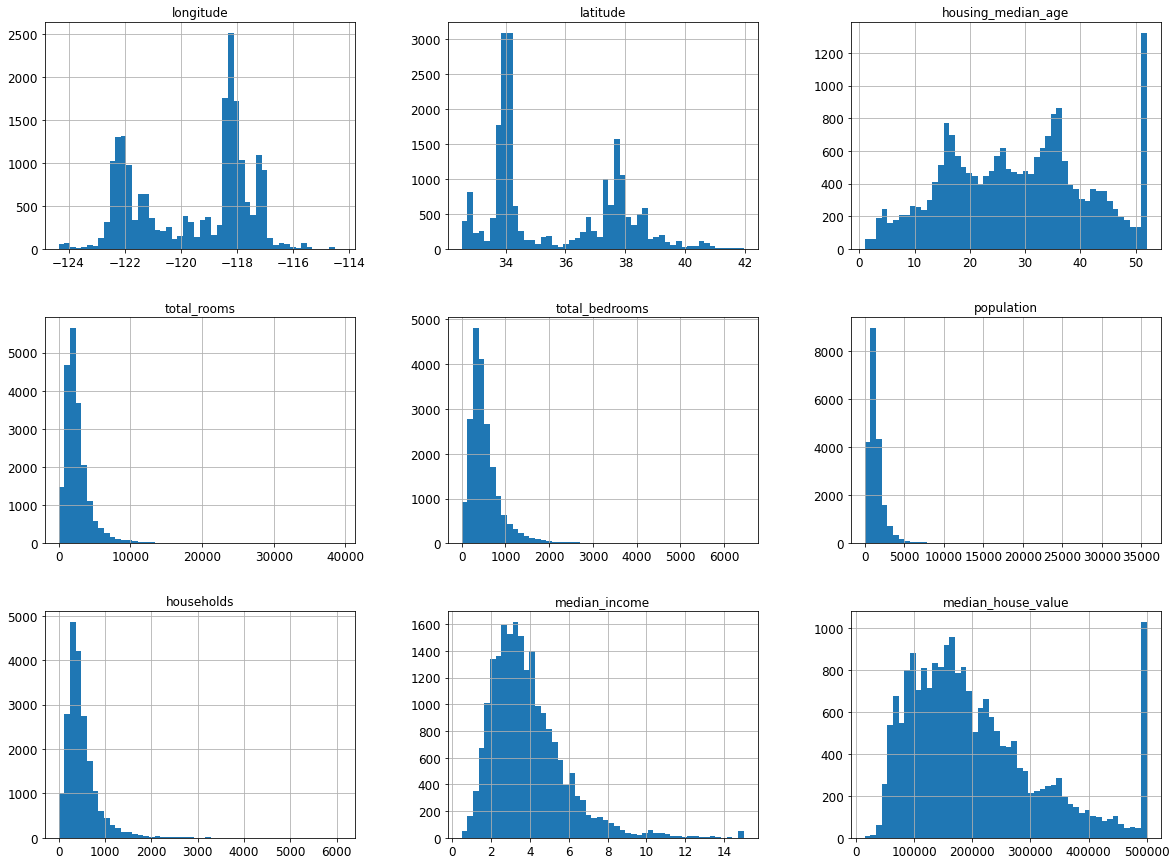

In [9]:
# 수치형 데이터 히스토그램
# housing_median_age , median_house_value 최소값과 최댓값이 한정되 있다.
# 컬럼값들의 단위가 다름으로 스케일링 필요 
# 정상적인 가우시안분포를 갖고 있지 않고 왼쪽으로 치우침이 있기 때문에 조정 필요 이런 형태는 일부 머신러닝 알고리즘에서 
# 패턴을 찾기 어렵게 만들기 때문에 특성들을 좀 더 종 모양의 분포가 되도록 변형 요망  

df.hist(bins=50, figsize=(20,15))
plt.show()

### Testset 

In [10]:
# train_test_split 함수 

def split_train_test(data, test_ratio):
    # permutation (순열) 정수배열을 랜덤하게 섞는다.
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [11]:
train_set, test_set = split_train_test(df, 0.2)
len(train_set)

16512

In [12]:
len(test_set)

4128

In [13]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [14]:
import hashlib

def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

In [15]:
def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

In [17]:
housing_with_id = df.reset_index()   # `index` 열이 추가된 데이터프레임을 반환합니다
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [18]:
housing_with_id["id"] = df["longitude"] * 1000 + df["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")


In [19]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
8,8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,-122222.16
10,10,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,281500.0,NEAR BAY,-122222.15
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY,-122222.15
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY,-122222.15
13,13,-122.26,37.84,52.0,696.0,191.0,345.0,174.0,2.6736,191300.0,NEAR BAY,-122222.16


In [21]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

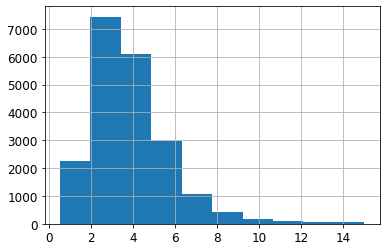

In [22]:
df["median_income"].hist()
plt.show()

In [23]:
# 중요도가 높은 컬럼인 median_income을 수치형에서 카테고리로 변경 ,여러 소득 카테고리를 대표하기 위해서
df['income_cat'] = pd.cut(df['median_income'] , bins = [0.,1.5,3.0,4.5,6, np.inf], labels =[1,2,3,4,5,])

In [24]:
df['income_cat'].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

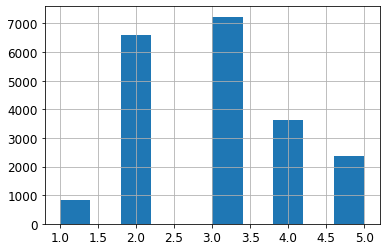

In [25]:
df['income_cat'].hist()
plt.show()

In [26]:
# 새로 생성한 imcome_cat 컬럼을 test, train에 균등하게 나누는 계층적 샘플링

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["income_cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [27]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [28]:
df["income_cat"].value_counts() / len(df)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64